# Hodgkin-Huxley example

In [1]:
%load_ext autoreload
%autoreload 2

import os
from typing import Any, Sequence
from copy import copy

import torch
import torch.utils.data as data

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import distrax 
import optax
import tensorflow_probability as tfp
tfp = tfp.substrates.jax
tfd = tfp.distributions

import sbi.utils as utils
import sbi.analysis as analysis
from sbi.inference import SNPE

from HH_helper_functions import syn_current, HHsimulator, calculate_summary_statistics

from jaxili.train import TrainerModule, TrainState
from jaxili.model import ConditionalMAF, ConditionalRealNVP
from jaxili.utils import create_data_loader

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

2024-03-15 15:18:59.731136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 15:18:59.731168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 15:18:59.731890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 15:19:00.487165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
I, t_on, t_off, dt, t, A_soma = syn_current()

In [3]:
def run_HH_model(params):

    params = np.asarray(params)

    #input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    #initial voltage
    V0 = -70

    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [4]:
#three sets of g_Na, g_K)
params = np.array([[50.0, 1.0], [4.0, 1.5], [20.0, 15.0]])

num_samples = len(params[:, 0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i, :] = run_HH_model(params = params[i, :])["data"]

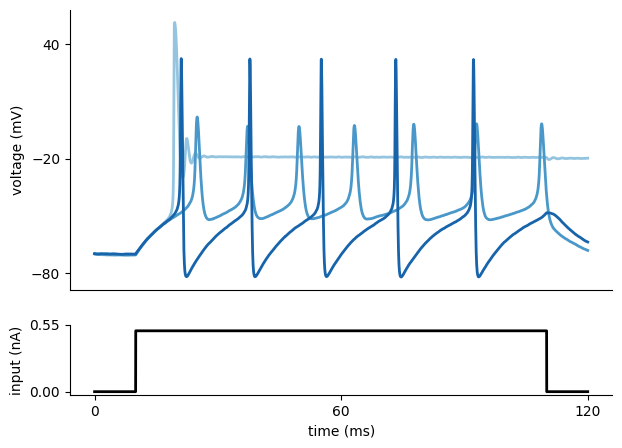

In [5]:
#colors for traces
col_min = 2

num_colors = num_samples + col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.0*i/num_colors) for i in range(col_min, num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t, sim_samples[i,:], color=col1[i], lw=2)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t, I*A_soma*1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
plt.show()

In [6]:
def simulation_wrapper(params):
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [7]:
prior_min = [0.5, 1e-4]
prior_max = [80.0, 15.0]
prior = utils.torchutils.BoxUniform(
    low = torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [8]:
thetas = prior.sample((300,))
xs = torch.stack([simulation_wrapper(theta) for theta in thetas])
xs = torch.as_tensor(xs, dtype=torch.float32)

In [9]:
print(thetas.shape, xs.shape)

torch.Size([300, 2]) torch.Size([300, 7])


In [10]:
inference = SNPE(prior, density_estimator='maf')

density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 142 epochs.

In [11]:
type(density_estimator)

nflows.flows.base.Flow

In [12]:
true_params = np.array([50.0, 5.0])
labels_params = [r"$g_{Na}$", r"$g_{K}$"]

observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

In [14]:
samples = posterior.sample((10000,), x=observation_summary_statistics)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

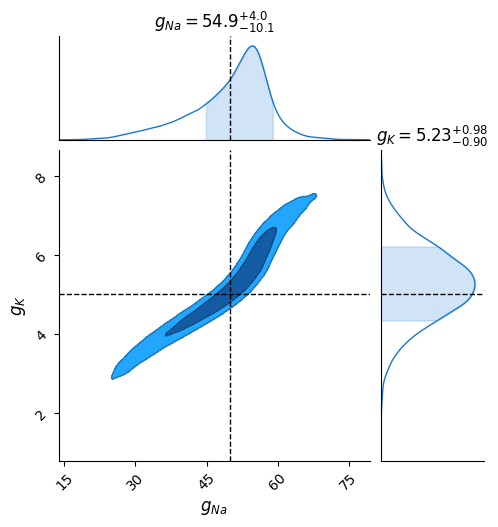

In [15]:
c = ChainConsumer()
c.add_chain(samples.numpy(), parameters=labels_params)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [16]:
#using jaxili

#Create the dataset
class HH_dataset(data.Dataset):
    def __init__(self, thetas, xs):
        self.thetas = thetas.numpy()
        self.xs = xs.numpy()

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]
    
    def set_params(self, thetas):
        self.thetas = thetas
    
    def set_data(self, xs):
        self.xs = xs
    
def generate_dataset(num_samples):
    thetas = prior.sample((num_samples,))
    xs = torch.stack([simulation_wrapper(theta) for theta in thetas])
    xs = torch.as_tensor(xs, dtype=torch.float32)
    return thetas, xs

train_set = HH_dataset(thetas, xs)
val_set = HH_dataset(*generate_dataset(100))
test_set = HH_dataset(*generate_dataset(200))

#Normalize the data
thetas, xs = train_set[:]
thetas_mean = thetas.mean(axis=0)
thetas_std = thetas.std(axis=0)
xs_mean = xs.mean(axis=0)
xs_std = xs.std(axis=0)
train_set.set_params((thetas - thetas_mean)/thetas_std)
train_set.set_data((xs - xs_mean)/xs_std)
thetas, xs = val_set[:]
val_set.set_params((thetas - thetas_mean)/thetas_std)
val_set.set_data((xs - xs_mean)/xs_std)
thetas, xs = test_set[:]
test_set.set_params((thetas - thetas_mean)/thetas_std)
test_set.set_data((xs - xs_mean)/xs_std)

#Create the model
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size=50
)

In [17]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 prior : Any = None,
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation,
                             'prior': prior
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Parameters
        ----------
        num_epochs : Number of epochs to train.
        num_steps_per_epoch : Number of steps per epoch.
        """

        hparams = copy(self.optimizer_hparams)

        #Initialize optimizer
        optimizer_name = hparams.pop('optimizer_name', 'adam')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        else:
            assert False, f'Unknown optimizer \"{optimizer_name}\"'
        #Initialize learning rate scheduler
        #A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0.1)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        #Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 5.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        #Initialize training state
        self.state = TrainState.create(
            apply_fn=self.state.apply_fn,
            params=self.state.params,
            batch_stats=self.state.batch_stats,
            tx=optimizer,
            rng=self.state.rng
        )
        
    def generate_config(self, logger_params):
        self.config = {
            'model_class': self.model_class.__name__,
            'model_hparams': copy(self.model_hparams),
            'optimizer_hparams': self.optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_epoch': self.check_val_every_epoch,
            'seed': self.seed
        }
        self.config['model_hparams']['prior'] = 'Uniform'
        
        
    def print_tabulate(self, exmp_input):
        pass

In [18]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = MAFTrainer(
    n_in=2,
    n_cond=7,
    n_layers=2,
    layers=[50, 50],
    use_reverse=True,
    seed=30,
    activation='relu',
    prior=None,
    optimizer_hparams={
        'lr': 5e-3,
        'optimizer_name': 'adam'
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None,
    debug=False
)

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


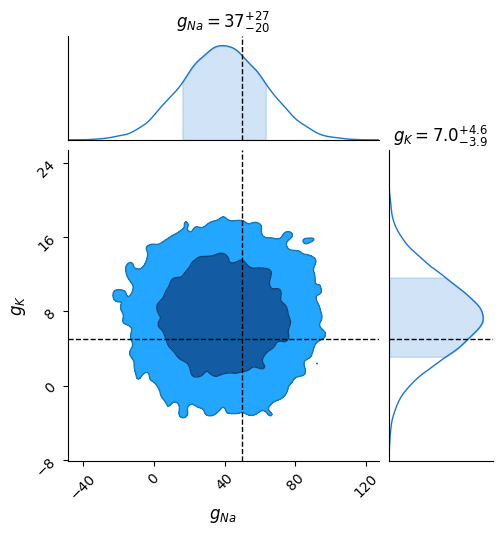

In [19]:
key = jax.random.PRNGKey(42)
pre_samples = trainer.model.apply(
    {'params': trainer.state.params}, (observation_summary_statistics.reshape((-1, 7))-xs_mean)/xs_std, num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(pre_samples*thetas_std+thetas_mean, parameters=labels_params)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [20]:
trainer.state.params

{'layer_list_0': {'ConditionalMADE_0': {'layers_0': {'Dense_0': {'kernel': Array([[ 7.15936953e-03,  6.16055587e-03, -7.25786947e-03,
             -7.71624560e-04, -2.51256372e-03,  8.96579400e-03,
             -7.19987415e-03,  8.41997098e-03,  1.46400509e-03,
              5.42372745e-03, -1.40737956e-02,  5.90637140e-03,
             -3.12761427e-03,  1.36629986e-02, -2.46096239e-03,
              1.32803386e-02,  5.33229113e-03, -1.10198259e-02,
              1.33980103e-02, -1.22190118e-04,  3.27070802e-03,
              1.12143280e-02, -1.11046610e-02, -1.26065351e-02,
              8.17432068e-03, -1.00590475e-02, -1.21866819e-02,
             -9.05267429e-03,  5.64356428e-03,  2.37286673e-03,
              2.62524304e-03, -9.54818912e-03,  1.61425192e-02,
              6.33796304e-03,  5.13219927e-03, -5.38471108e-03,
             -2.96553224e-03,  6.96427072e-04,  1.88763766e-03,
             -6.98278472e-03,  6.20205607e-03,  4.59443685e-03,
             -1.49557739e-03,  5.3

In [21]:
trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/chec

Training:   0%|          | 0/6 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 2
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_2.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/chec

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 3
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_3.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_3.orbax-checkpoint-tmp-1710513108037259 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_3
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_3`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_2


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 4
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_4.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_4.orbax-checkpoint-tmp-1710513108202216 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_4
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_4`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_3


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_5.orbax-checkpoint-tmp-1710513108401284 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_5`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_4


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 6
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_6.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_6.orbax-checkpoint-tmp-1710513108558785 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_6
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_6`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_5


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 7
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_7.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_7.orbax-checkpoint-tmp-1710513108731339 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_7
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_7`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_6


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 9
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_9.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_9.orbax-checkpoint-tmp-1710513109042818 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_9
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_9`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_7


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 10
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_10.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_10.orbax-checkpoint-tmp-1710513109269356 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_10
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_10`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_9


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 11
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_11.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_11.orbax-checkpoint-tmp-1710513109433373 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_11
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_11`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_10


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 13
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_13.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_13.orbax-checkpoint-tmp-1710513109791717 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_13
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_13`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_11


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 15
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_15.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_15.orbax-checkpoint-tmp-1710513110128197 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_15
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_15`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_13


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 16
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_16.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_16.orbax-checkpoint-tmp-1710513110293375 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_16
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_16`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_15


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 18
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_18.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_18.orbax-checkpoint-tmp-1710513110616034 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_18
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_18`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_16


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 19
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_19.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_19.orbax-checkpoint-tmp-1710513110791807 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_19
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_19`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_18


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 20
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_20.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_20.orbax-checkpoint-tmp-1710513110979135 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_20
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_20`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_19


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 26
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_26.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_26.orbax-checkpoint-tmp-1710513112007448 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_26
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_26`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_20


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 31
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_31.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_31.orbax-checkpoint-tmp-1710513112840204 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_31
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_31`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_26


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 35
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_35.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_35.orbax-checkpoint-tmp-1710513113467533 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_35
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_35`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_31


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 42
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_42.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_42.orbax-checkpoint-tmp-1710513114639188 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_42
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_42`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_35


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 45
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_45.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_45.orbax-checkpoint-tmp-1710513115115512 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_45
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_45`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_42


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 46
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_46.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_46.orbax-checkpoint-tmp-1710513115298432 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_46
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_46`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_45


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 47
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_47.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_47.orbax-checkpoint-tmp-1710513115508733 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_47
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_47`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_46


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 51
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_51.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_51.orbax-checkpoint-tmp-1710513116262342 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_51
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_51`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_47


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 58
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_58.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_58.orbax-checkpoint-tmp-1710513117528837 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_58
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_58`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_51


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 77
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_77.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_77.orbax-checkpoint-tmp-1710513121307822 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_77
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_77`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_58


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 79
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_79.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_79.orbax-checkpoint-tmp-1710513121706767 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_79
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_79`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_77


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 96
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_96.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_96.orbax-checkpoint-tmp-1710513124522830 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_96
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_96`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_79


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 101
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_101.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_101.orbax-checkpoint-tmp-1710513125333472 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_101
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_101`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_96


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 110
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_110.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_110.orbax-checkpoint-tmp-1710513126713222 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_110
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_110`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_101


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 112
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_112.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_112.orbax-checkpoint-tmp-1710513127110736 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_112
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_112`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_110


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 126
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_126.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_126.orbax-checkpoint-tmp-1710513129460149 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_126
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_126`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_112


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 140
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_140.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_140.orbax-checkpoint-tmp-1710513131655531 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_140
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_140`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_126


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 144
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_144.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_144.orbax-checkpoint-tmp-1710513132292834 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_144
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_144`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_140


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 146
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_146.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_146.orbax-checkpoint-tmp-1710513132623433 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_146
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_146`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_144


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_146
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_146.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_80/checkpoint_146.


Neural network training stopped after 167 epochs.
Early stopping with best validation metric: -3.8413848876953125
Best model saved at epoch 146
Early stopping parameters: min_delta=0.001, patience=20


{'val/loss': -3.8413848876953125,
 'train/loss': -4.574248790740967,
 'epoch_time': 0.014448881149291992,
 'test/loss': -4.018581390380859}

In [22]:
model = trainer.bind_model()

In [23]:
key = jax.random.PRNGKey(42)
jaxili_samples = model.sample((observation_summary_statistics.reshape((-1, 7))-xs_mean)/xs_std, num_samples=10000, key=key)

c = ChainConsumer()
c.add_chain(jaxili_samples*thetas_std+thetas_mean, parameters=labels_params, label="sbi")
c.add_chain(samples.numpy(), parameters=labels_params, label="JaxILI")
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

TypeError: ChainConsumer.add_chain() got an unexpected keyword argument 'label'

In [ ]:
log_prob = model.log_prob(jaxili_samples, (observation_summary_statistics.reshape((-1, 7))-xs_mean)/xs_std*jnp.ones((10000, 1)))

In [ ]:
-jnp.mean(log_prob)-np.sum(np.log(1/thetas_mean))

Array(1.5460353, dtype=float32)